In [ ]:
!pip install tensorflow numpy scikit-learn Pillow
!pip install --upgrade pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from IPython.display import Image
import pickle

In [ ]:
deforestation_dir = "/content/dataset/deforestation"
no_deforestation_dir = "/content/dataset/no_deforestation"

images = []
labels = []

In [ ]:
for filename in os.listdir(deforestation_dir):
    img_path = os.path.join(deforestation_dir, filename)
    try:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(1)
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

In [ ]:
for filename in os.listdir(no_deforestation_dir):
    img_path = os.path.join(no_deforestation_dir, filename)
    try:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(0)
    except Exception as e:
        print(f"Error loading image {filename}: {e}")

Error loading image .ipynb_checkpoints: [Errno 21] Is a directory: '/content/dataset/no_deforestation/.ipynb_checkpoints'


In [ ]:
images = np.array(images)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.4645 - loss: 2.1516 - val_accuracy: 0.5769 - val_loss: 0.7303
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5925 - loss: 0.7718 - val_accuracy: 0.5769 - val_loss: 0.6313
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.7030 - loss: 0.5990 - val_accuracy: 0.8077 - val_loss: 0.4527
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8102 - loss: 0.4970 - val_accuracy: 0.9615 - val_loss: 0.2424
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8026 - loss: 0.4897 - val_accuracy: 0.8462 - val_loss: 0.4472
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8300 - loss: 0.3310 - val_accuracy: 0.9231 - val_loss: 0.1916
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8560 - loss: 0.3412 - val_accuracy: 0.8462 - val_loss: 0.3940
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.4898 - loss: 0.8798 - val_accuracy: 0.9231 - val_loss: 0.2548
Epoch 9/

In [ ]:
model.save("/content/deforestation_model.h5")

In [ ]:
def predict_and_store(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        prediction = model.predict(img_array)

        if prediction[0][0] >= 0.5:
            prediction_label = "Deforestation Detected."
            destination_folder = "/content/deforested_images"
        else:
            prediction_label = "No Deforestation Detected."
            destination_folder = "/content/no_deforested_images"

        os.makedirs(destination_folder, exist_ok=True)

        filename = os.path.basename(image_path)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy(image_path, destination_path)

        with open("/content/deforestation.pkl", "wb") as f:
            pickle.dump(model, f)

        return prediction_label, destination_path

    except Exception as e:
        return f"Error processing image: {e}", None

In [ ]:
os.makedirs("/content/deforested_images", exist_ok=True)
os.makedirs("/content/no_deforested_images", exist_ok=True)

Saving img61.png to img61 (1).png
Saving img62.png to img62 (1).png
Saving img63.png to img63 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Image: img61 (1).png
Prediction: Deforestation Detected.
Image stored at: /content/deforested_images/img61 (1).png


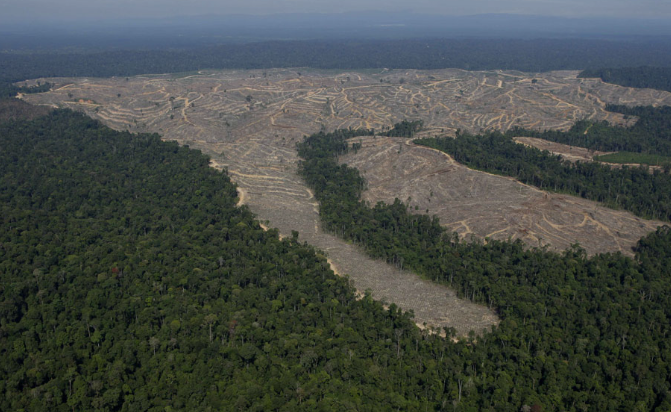

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Image: img62 (1).png
Prediction: Deforestation Detected.
Image stored at: /content/deforested_images/img62 (1).png


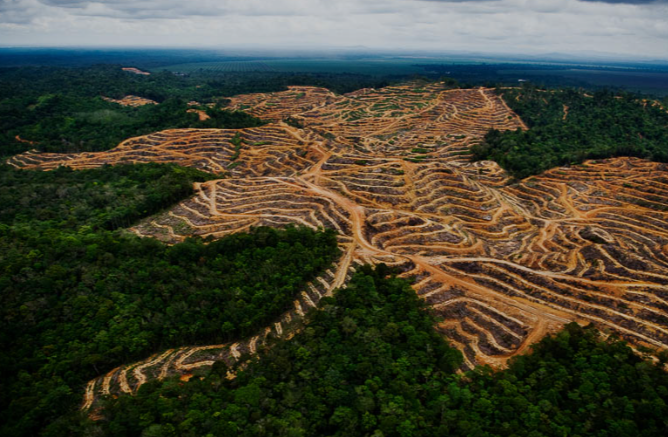

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Image: img63 (1).png
Prediction: Deforestation Detected.
Image stored at: /content/deforested_images/img63 (1).png


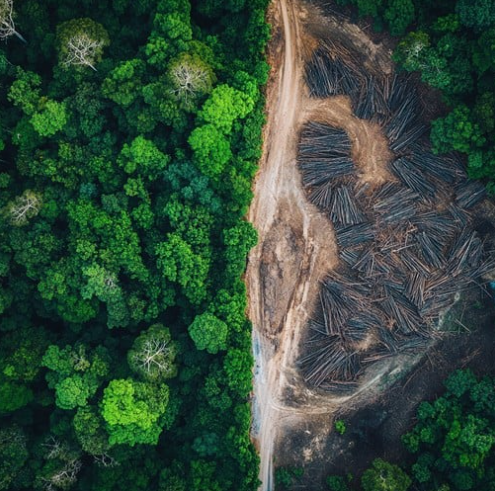

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    image_path = fn
    prediction, stored_path = predict_and_store(image_path)

    print(f"Image: {fn}")
    print(f"Prediction: {prediction}")
    if stored_path:
        print(f"Image stored at: {stored_path}")


        try:
            display(Image(image_path))
        except Exception as e:
            print(f"Error displaying image: {e}")